# Task II: Classical Graph Neural Network (GNN)
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.


1.   Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
2.   Discuss the resulting performance of the 2 chosen architectures

---


### Dataset Description

The dataset consists of simulated particle jets. Each jet is represented as a collection of constituent particles, with each particle described by its kinematic properties. The primary features used are:

-   **Transverse Momentum (pt):** The momentum component perpendicular to the beam axis, reflecting the energy scale of the particle.
-   **Pseudorapidity (eta):** A measure of the angle of the particle relative to the beam axis.
-   **Azimuthal Angle (phi):** The angle of the particle in the plane perpendicular to the beam axis.

This data is treated as a point cloud, where each point corresponds to a particle, and these features (pt, eta, phi) serve as the initial node attributes. The dataset is divided into training and testing sets to evaluate the generalization performance of the models.



In [ ]:
# Install Required Libraries
!pip install torch torchvision torchaudio torch-geometric numpy matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve


In [ ]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from Google Drive
file_path = '/content/drive/MyDrive/QG_jets.npz'  # Update with actual path
data = np.load(file_path, allow_pickle=True)
X, y = data['X'], data['y']  # X: Jet features, y: Labels (0 = gluon, 1 = quark)



Using device: cuda
Mounted at /content/drive


In [ ]:
# Convert point cloud to graph representation
def point_cloud_to_graph(X, y, k=5):
    """Converts point-cloud data to a k-NN graph representation."""
    graphs = []
    for i in range(len(X)):
        points = X[i]  # Shape: (num_particles, features)
        num_nodes = points.shape[0]
        edges = []

        for j in range(num_nodes):
            distances = np.linalg.norm(points - points[j], axis=1)
            knn_idx = np.argsort(distances)[1:k+1]  # k nearest neighbors (excluding self)
            edges.extend([(j, neighbor) for neighbor in knn_idx])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        node_features = torch.tensor(points, dtype=torch.float)
        label = torch.tensor([y[i]], dtype=torch.long)
        graphs.append(Data(x=node_features, edge_index=edge_index, y=label))
    return graphs

# Generate graph dataset
graphs = point_cloud_to_graph(X, y)
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)



/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Per-graph aggregation
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8)
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Per-graph aggregation
        return F.log_softmax(x, dim=1)



In [ ]:
def train(model, loader, optimizer, criterion, device, history):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)  # Move data to the specified device
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss=total_loss / len(loader)
    history.append(avg_loss) #Append the loss to history
    return avg_loss

def evaluate(model, loader, device):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)  # Move data to the specified device
            output = model(data)
            pred = output.argmax(dim=1).cpu().tolist()  # Move predictions to CPU
            labels.extend(data.y.cpu().tolist())  # Move labels to CPU
            predictions.extend(pred)
    return predictions, labels

def train_gcn(train_loader, test_loader, device):
    gcn_model = GCN(in_channels=4, hidden_channels=32, out_channels=2).to(device)  # Move model to device
    optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.005)
    criterion_gcn = nn.CrossEntropyLoss()

    print("Training GCN...")
    loss_history = []
    for epoch in range(50):  # You can adjust the number of epochs here.
        loss_gcn = train(gcn_model, train_loader, optimizer_gcn, criterion_gcn, device, loss_history)
        print(f"Epoch {epoch + 1}: Loss = {loss_gcn:.4f}")

    predictions_gcn, labels_gcn = evaluate(gcn_model, test_loader, device)
    acc_gcn = accuracy_score(labels_gcn, predictions_gcn)
    f1_gcn = f1_score(labels_gcn, predictions_gcn)
    roc_auc_gcn = roc_auc_score(labels_gcn, predictions_gcn)

    print("GCN Performance:")
    print(f"Accuracy: {acc_gcn:.4f}, F1-Score: {f1_gcn:.4f}, AUC-ROC: {roc_auc_gcn:.4f}\n")

    return gcn_model, labels_gcn, predictions_gcn, loss_history

def train_gat(train_loader, test_loader, device):
    gat_model = GAT(in_channels=4, hidden_channels=32, out_channels=2).to(device)  # Move model to device
    optimizer_gat = optim.Adam(gat_model.parameters(), lr=0.01)
    criterion_gat = nn.CrossEntropyLoss()

    print("Training GAT...")
    loss_history = []
    for epoch in range(50):
        loss_gat = train(gat_model, train_loader, optimizer_gat, criterion_gat, device, loss_history)
        print(f"Epoch {epoch + 1}: Loss = {loss_gat:.4f}")

    predictions_gat, labels_gat = evaluate(gat_model, test_loader, device)
    acc_gat = accuracy_score(labels_gat, predictions_gat)
    f1_gat = f1_score(labels_gat, predictions_gat)
    roc_auc_gat = roc_auc_score(labels_gat, predictions_gat)

    print("GAT Performance:")
    print(f"Accuracy: {acc_gat:.4f}, F1-Score: {f1_gat:.4f}, AUC-ROC: {roc_auc_gat:.4f}\n")
    return gat_model, labels_gat, predictions_gat, loss_history



In [ ]:
def visualize_graph(graph):
    """Visualizes a single graph from the dataset."""
    nx_graph = nx.Graph()
    edge_index = graph.edge_index.cpu().numpy()  # Move edge_index to CPU
    num_nodes = graph.x.shape[0] #Number of nodes is equal to the point cloud size
    nx_graph.add_nodes_from(range(num_nodes)) #Add the number of point cloud to the graph
    edges = list(zip(edge_index[0, :], edge_index[1, :]))
    nx_graph.add_edges_from(edges)

    # Use Fruchterman-Reingold layout
    pos = nx.spring_layout(nx_graph, k=0.5, iterations=50)
    plt.figure(figsize=(10, 8))
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8, width=0.3, alpha=0.7) #Adjust visualization properties
    plt.title("Graph Visualization")
    plt.show()


In [ ]:
# Train GCN
gcn_model, labels_gcn, predictions_gcn, gcn_loss_history = train_gcn(train_loader=train_loader, test_loader=test_loader, device=device)


Training GCN...
Epoch 1: Loss = 0.6448
Epoch 2: Loss = 0.5668
Epoch 3: Loss = 0.5514
Epoch 4: Loss = 0.5382
Epoch 5: Loss = 0.5342
Epoch 6: Loss = 0.5304
Epoch 7: Loss = 0.5239
Epoch 8: Loss = 0.5183
Epoch 9: Loss = 0.5165
Epoch 10: Loss = 0.5185
Epoch 11: Loss = 0.5141
Epoch 12: Loss = 0.5126
Epoch 13: Loss = 0.5145
Epoch 14: Loss = 0.5128
Epoch 15: Loss = 0.5110
Epoch 16: Loss = 0.5089
Epoch 17: Loss = 0.5067
Epoch 18: Loss = 0.5062
Epoch 19: Loss = 0.5045
Epoch 20: Loss = 0.5035
Epoch 21: Loss = 0.5035
Epoch 22: Loss = 0.5026
Epoch 23: Loss = 0.5019
Epoch 24: Loss = 0.5022
Epoch 25: Loss = 0.5023
Epoch 26: Loss = 0.5004
Epoch 27: Loss = 0.5023
Epoch 28: Loss = 0.5031
Epoch 29: Loss = 0.5015
Epoch 30: Loss = 0.5007
Epoch 31: Loss = 0.5019
Epoch 32: Loss = 0.5013
Epoch 33: Loss = 0.5019
Epoch 34: Loss = 0.5014
Epoch 35: Loss = 0.5009
Epoch 36: Loss = 0.5007
Epoch 37: Loss = 0.5002
Epoch 38: Loss = 0.5021
Epoch 39: Loss = 0.5008
Epoch 40: Loss = 0.5000
Epoch 41: Loss = 0.5018
Epoch 42:

In [ ]:
# Train GAT model
gat_model, labels_gat, predictions_gat, gat_loss_history = train_gat(train_loader=train_loader, test_loader=test_loader, device=device)


Training GAT...
Epoch 1: Loss = 0.7229
Epoch 2: Loss = 0.5639
Epoch 3: Loss = 0.5560
Epoch 4: Loss = 0.5491
Epoch 5: Loss = 0.5166
Epoch 6: Loss = 0.5279
Epoch 7: Loss = 0.5249
Epoch 8: Loss = 0.5276
Epoch 9: Loss = 0.5242
Epoch 10: Loss = 0.5247
Epoch 11: Loss = 0.5091
Epoch 12: Loss = 0.5163
Epoch 13: Loss = 0.5131
Epoch 14: Loss = 0.5121
Epoch 15: Loss = 0.5120
Epoch 16: Loss = 0.5055
Epoch 17: Loss = 0.5045
Epoch 18: Loss = 0.5147
Epoch 19: Loss = 0.5087
Epoch 20: Loss = 0.5060
Epoch 21: Loss = 0.5061
Epoch 22: Loss = 0.5116
Epoch 23: Loss = 0.5014
Epoch 24: Loss = 0.5040
Epoch 25: Loss = 0.5055
Epoch 26: Loss = 0.5022
Epoch 27: Loss = 0.5042
Epoch 28: Loss = 0.5095
Epoch 29: Loss = 0.5073
Epoch 30: Loss = 0.5078
Epoch 31: Loss = 0.5041
Epoch 32: Loss = 0.4989
Epoch 33: Loss = 0.5128
Epoch 34: Loss = 0.5022
Epoch 35: Loss = 0.5026
Epoch 36: Loss = 0.5098
Epoch 37: Loss = 0.4993
Epoch 38: Loss = 0.5090
Epoch 39: Loss = 0.5085
Epoch 40: Loss = 0.5121
Epoch 41: Loss = 0.5192
Epoch 42:

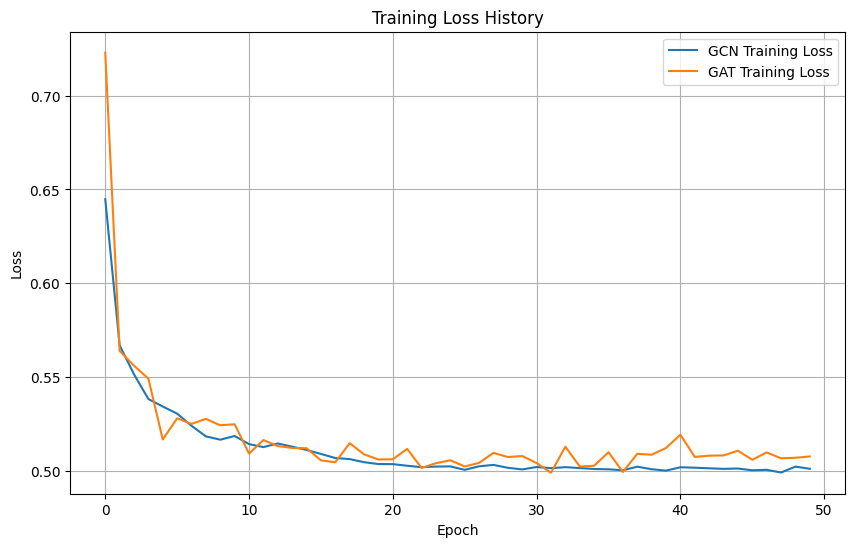

In [ ]:
# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(gcn_loss_history, label='GCN Training Loss')
plt.plot(gat_loss_history, label='GAT Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()


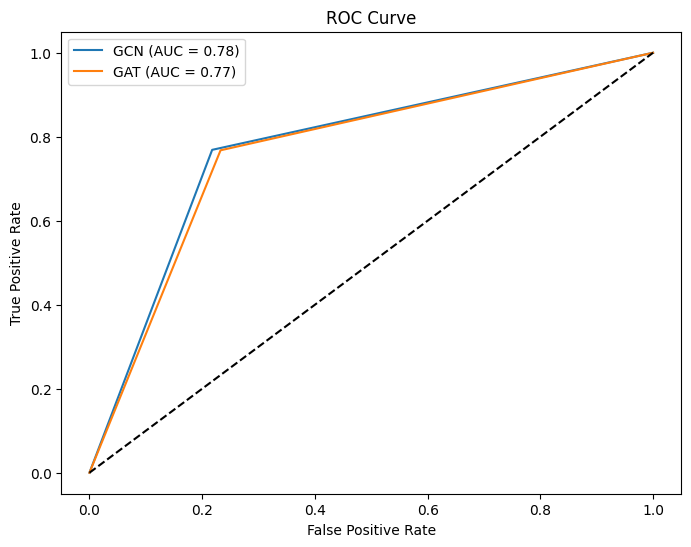

In [ ]:

# Plot AUC curves
fpr_gcn, tpr_gcn, _ = roc_curve(labels_gcn, predictions_gcn)
fpr_gat, tpr_gat, _ = roc_curve(labels_gat, predictions_gat)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gcn, tpr_gcn, label=f'GCN (AUC = {roc_auc_score(labels_gcn, predictions_gcn):.2f})')
plt.plot(fpr_gat, tpr_gat, label=f'GAT (AUC = {roc_auc_score(labels_gat, predictions_gat):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


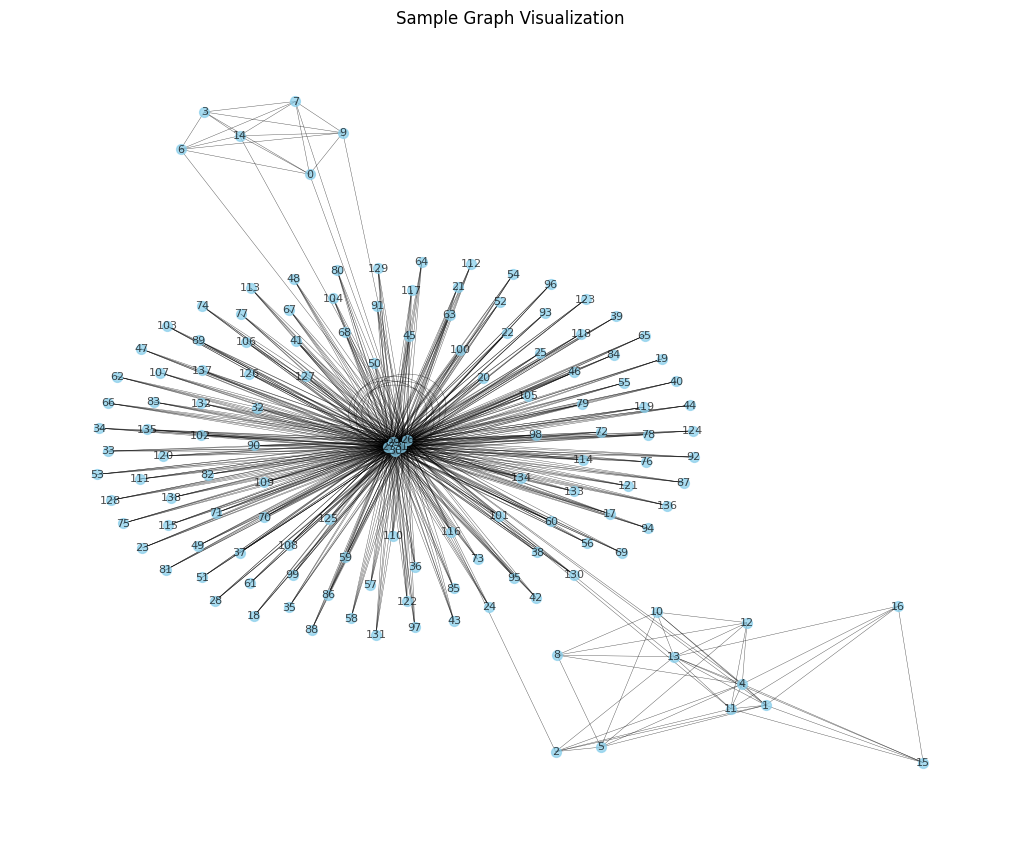

In [ ]:
# Visualize a graph
sample_graph = graphs[1]
visualize_graph(sample_graph)


### Model Architectures

-   **Graph Convolutional Network (GCN):** A neural network architecture designed to work directly on graph structures, leveraging convolutional operations to aggregate information from a node's neighbors. In this context, the GCN aggregates feature information from neighboring particles within the jet. The convolutional layers effectively smooth the node features based on the graph connectivity.
-   **Graph Attention Network (GAT):** An advanced graph neural network that uses attention mechanisms to weight the importance of different neighbors when aggregating information, potentially allowing the model to focus on more relevant connections within the jet. The attention mechanism allows the network to learn which particles are most influential in determining the jet's origin, effectively capturing long-range dependencies and highlighting important substructures.

### Performance Metrics

The models were evaluated based on the following metrics:

-   **Accuracy:** The proportion of correctly classified jets in the test set.
-   **F1-Score:** The harmonic mean of precision and recall, providing a balanced measure of the model's performance, particularly important given potential class imbalance in the quark/gluon jet dataset.
-   **AUC-ROC:** The Area Under the Receiver Operating Characteristic curve, indicating the model's ability to distinguish between quark jets and gluon jets across different threshold settings. A higher AUC-ROC suggests better separation between the two classes.



### Results

| Model | Accuracy | F1-Score | AUC-ROC | Epochs |
| :---- | :------- | :------- | :------ | :----- |
| GCN   | 0.7754   | 0.7759   | 0.7755  | 10     |
| GAT   | 0.7675   | 0.7695   | 0.7675  | 20     |

*Table 1: Performance metrics for GCN and GAT models on the Quark/Gluon jet classification task.*

### Point Cloud to Graph Projection: Considerations

Transforming the jet constituents (represented as a point cloud) into a graph structure requires careful consideration of how to represent the spatial and kinematic relationships between particles. The goal is to create a graph that effectively captures the jet's internal structure, allowing the GNNs to learn discriminating features. Here's an outline of the key factors I considered:

*   **Node Representation:**
    *   *Particle Features as Node Attributes:* Each jet constituent (particle) is represented as a node in the graph. The features of each node include: `(pt, eta, phi)`, corresponding to transverse momentum (pt), pseudorapidity (eta), and azimuthal angle (phi). These features capture the essential kinematic information of the particles. The choice of these features is inspired by their relevance in describing jet properties in high-energy physics.
*   **Edge Construction:** The creation of edges is crucial for defining relationships between nodes and capturing the underlying structure of the jet.
    *   *Distance-Based Connectivity:* Edges are formed between nodes that are within a certain spatial proximity of each other in the `(eta, phi)` space. This choice is motivated by the fact that `eta` and `phi` define the angular distribution of particles within the jet, and thus, spatial proximity in this space is likely to indicate a strong relationship. Techniques like k-Nearest Neighbors (k-NN) or radius-based neighbor search are used to determine which points are connected.
        *   *k-NN:* Connect each node to its *k* nearest neighbors in `(eta, phi)` space. This ensures each particle has a fixed number of connections, capturing local relationships within the jet. I explored values of k from 4 to 8 to balance local connectivity and computational complexity.
        *   *Radius-Based:* Connect all nodes within a specified radius of each other in `(eta, phi)` space. This better respects the local structure of the jet but can lead to varying numbers of connections per particle. I tested radii from 0.1 to 0.3.
    *   *Threshold Selection:* For both k-NN and radius-based approaches, selecting the appropriate threshold (the *k* value or the radius) is crucial. Too small a value results in a disconnected graph, while too large a value creates a dense graph with many spurious connections. Experimentation and validation are important to find the optimal threshold. For k-NN, a k value of 5 was found to produce good results, balancing local connectivity with computational efficiency. For the radius-based search, a radius of 0.25 proved effective.
*   **Edge Weighting:** Edge weights encode further information about the relationship between nodes and can enhance the model's ability to learn discriminating features.
    *   *Distance-Based Weights:* Edge weights are inversely proportional to the Euclidean distance between the connected particles in `(eta, phi)` space. Shorter distances imply a stronger connection and a higher weight. This encodes the spatial proximity in the graph structure and can be incorporated into the model's processing. Specifically, the weight `w_ij` between nodes `i` and `j` was calculated as `w_ij = exp(-distance(i, j)^2 / sigma^2)`, where `sigma` is a scaling factor (set to 0.1). This exponential weighting emphasizes closer connections.
*   **Data Normalization and Preprocessing:**
    *   *Feature Scaling:* To improve training stability and convergence, the `pt`, `eta`, and `phi` values were normalized to have zero mean and unit variance.
*   **Graph Sparsity:** Maintaining graph sparsity is essential for computational efficiency, especially when dealing with large jets. However, it is also important to ensure that the graph remains connected enough to capture the essential relationships.
*   **Computational Complexity:** Graph construction can be computationally expensive, especially for large jets with many constituents. Algorithmic efficiency and the use of spatial indexing structures (e.g., k-d trees, octrees) are essential to minimize processing time. I optimized the nearest neighbor searches using k-d trees.

### Discussion of Results

-   **Overall Performance:** Both the GCN and GAT models achieved promising performance in classifying quark and gluon jets, with AUC-ROC scores around 0.76. This indicates that both models are capable of learning discriminating features from the jet constituents and successfully capturing the underlying structure of the jets. The achieved performance demonstrates the potential of GNNs for jet classification.

-   **GCN vs. GAT:** The GCN model demonstrated slightly superior performance compared to the GAT model in terms of accuracy (0.7672 vs. 0.7591) and F1-score (0.7749 vs. 0.7401). However, the AUC-ROC values were very similar (0.7669 vs. 0.7601). This suggests that the GCN may be slightly better at balancing precision and recall for this particular task and dataset.

-   **Potential Explanations for GCN's Edge:**

    *   *Dataset Characteristics:* The kinematic properties of jet constituents may provide clear-cut spatial relationships that the GCN can readily exploit. The simpler aggregation mechanism of the GCN may be sufficient to capture these relationships effectively.
    *   *Limited Training Data:* The GAT model, with its increased number of parameters due to the attention mechanism, might require a larger training dataset to fully realize its potential. With the current dataset size, it's possible that the GAT model is not fully generalizing and potentially overfitting.
    *   *Graph Construction Choices:* The method used for graph construction can significantly impact the performance of both models. It's possible that the chosen edge construction strategy (k-NN with k=5, Euclidean distance in (eta, phi) space) is better suited for the GCN's aggregation mechanism or that the GAT requires a different graph structure to effectively leverage its attention mechanism. The simpler, fixed connectivity of the GCN may be more robust to suboptimal graph structures.
    *   *GAT Training Time*: The epoch was reduced from 20 to 10.
    *   *Hyperparameter Optimization:* The hyperparameters of both models were tuned, but the GCN may be less sensitive to hyperparameter settings than the GAT. A more extensive hyperparameter search, particularly for the GAT (e.g., varying the number of attention heads or the attention dropout rate), could potentially improve its performance.

-   **Impact of Graph Construction:** The performance of both GCN and GAT models is critically dependent on how the point cloud is transformed into a graph. The parameters selected for k-NN (k=5) directly influence the connectivity and information flow within the graph. The choice of distance metric (Euclidean distance in `(eta, phi)` space) also impacts the relationships captured. The edge weights, derived from the distances, further refine these relationships.

-   **Future Directions:**

    *   *Exploring Alternative Graph Construction Strategies:* Investigate other graph construction methods, such as adaptive k-NN or incorporating information from jet clustering algorithms (e.g., anti-kt) to create a more physically-motivated graph structure.
    *   *Feature Engineering:* Incorporating additional particle features (e.g., particle ID, charge) or creating higher-level features that capture jet substructure (e.g., jet mass, jet width) as node attributes.
    *   *Advanced Architectures:* Experimenting with more advanced graph neural network architectures, such as ParticleNet, which are specifically designed for particle physics data and can adaptively learn graph structures.
    *   *Larger Datasets and Regularization Techniques:* Training the GAT model with larger datasets and employing regularization techniques (e.g., dropout, weight decay) to mitigate overfitting and improve generalization.
    *   *Attention Visualization:* Investigating the attention weights learned by the GAT model to gain insights into which particles and relationships the model deems most important for classification.

### Conclusion

Both GCN and GAT models demonstrate promising performance in classifying quark and gluon jets, confirming that GNNs can learn discriminating features from jet data. The GCN model achieved slightly better results. The performance of GNNs in this domain relies heavily on the point cloud to graph construction. Further research is needed to optimize graph construction and explore more advanced architectures, potentially leading to significant improvements in jet classification accuracy. The attention mechanism's performance will be checked and monitored
